In [3]:
import ast
import imdb
import json
import pickle
import itertools
import dateparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ast import literal_eval
from price_parser import Price
from collections import Counter

%matplotlib inline

#### Step 1: Preprocessing, data scraping

In [4]:
DATA_COLUMNS = ["index","wikipedia_id", "imdb_id", "title", "cast", "genres", "runtimes", "countries", "languages", "box_office", "rating", "votes", "plot", "synopsis"]

df = pd.read_csv("./Data/fetched_data.csv", names=DATA_COLUMNS, header=0, index_col=0)

In [43]:
df["title"] = df["title"].astype("string")
df.cast = df.cast.apply(lambda x: literal_eval(x))
df.genres = df.genres.apply(lambda x: [] if pd.isna(x) else literal_eval(x))
df["runtimes"] = pd.to_numeric(df["runtimes"].apply(lambda x: "0" if pd.isna(x) else x.replace("[", "").replace("]", "").replace("'", "")))
df.countries = df.countries.apply(lambda x: [] if pd.isna(x) else literal_eval(x))
df.languages = df.languages.apply(lambda x: [] if pd.isna(x) else literal_eval(x))
df["synopsis"] = df["synopsis"].apply(lambda x: "" if pd.isna(x) else literal_eval(x)[0])
df["plot"] = df["plot"].apply(lambda x: "" if pd.isna(x) else literal_eval(x)[0])

In [44]:
# TODO question assistant => comment avoir la bonne valeur de box office en dollar 
# sachant que le cours a evolue au cours du temps

def convert_currency(x):
    formated = Price.fromstring(x)
    amount = formated.amount_float
    match formated.currency:
        case "$":
            return amount
        case "EUR":
            return amount * 1.18
        case "GBP":
            return amount * 1.36
        case "SEK":
            return amount * 0.11
        case "CAD":
            return amount * 0.79
        case "INR":
            return amount * 0.013
        case "CZK":
            return amount * 0.04
        case "JPY":
            return amount * 0.009
        case _:
            return None
    

In [45]:
# lets format the box office column

def superfunction(box_office):
    if pd.isna(box_office):
        return None, None, None
    film = ast.literal_eval(box_office)
    budget = convert_currency(film["Budget"]) if "Budget" in film else None
    bo_usa = Price.fromstring(film["Opening Weekend United States"]).amount if "Opening Weekend United States" in film else None
    bo_world = Price.fromstring(film["Cumulative Worldwide Gross"]).amount if "Cumulative Worldwide Gross" in film else None
    return budget, bo_usa, bo_world
    
formated_bo = df["box_office"].apply(lambda x: superfunction(x))
df["budget"], df["box_office_usa"], df["box_office_world"] = zip(*formated_bo)


In [46]:
years_df = pd.read_csv("./Data/movie.metadata.tsv", sep='\t', header=None)

In [47]:
# for each movies we have in df, find by id the one in years df
def parse_date(x):
    timestamped_fetched = years_df[years_df[0] == x][3].values
    year = dateparser.parse(timestamped_fetched[0]).year
    return year

df["release_year"] = df.wikipedia_id.apply(lambda x: parse_date(x))
df.drop(columns=["box_office"], inplace=True)

In [48]:
df.to_csv("./Data/cleaned_data.csv")

#### Step 2: Investigating the evolution of movie production over time and finding main character

In [5]:
df = pd.read_csv("./Data/cleaned_data.csv", index_col=0, header=0)
df.head()

,wikipedia_id,imdb_id,title,cast,genres,runtimes,countries,languages,rating,votes,plot,synopsis,budget,box_office_usa,box_office_world,release_year
index,,,,,,,,,,,,,,,,
0,975900,228333,ghosts of mars,"['Natasha Henstridge', 'Ice Cube', 'Jason Stat...","['Action', 'Horror', 'Sci-Fi']",98,['United States'],['English'],4.9,55370,"In 2176, a Martian police unit is sent to pick...","200 years in the future, Mars has been coloniz...",28000000.0,NaN,NaN,2001
1,28463795,94806,brun bitter,"['Frank Krog', 'Kristin Kajander', 'Anne Krigs...","['Crime', 'Drama']",83,['Norway'],['Norwegian'],5.7,40,"The lonely, divorced and disillusioned lawyer ...",NaN,NaN,NaN,NaN,1988
2,261236,83949,a woman in flames,"['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",['Drama'],106,['West Germany'],['German'],6.0,591,"Eva, an upper-class housewife, frustratingly l...",NaN,NaN,NaN,NaN,1983
3,10408933,29852,alexander's ragtime band,"['Tyrone Power', 'Alice Faye', 'Don Ameche', '...","['Drama', 'Music', 'Musical', 'Romance']",106,['United States'],['English'],6.9,2164,This send-up of ragtime song and dance begins ...,NaN,2000000.0,NaN,NaN,1938
4,175026,21335,sarah and son,"['Ruth Chatterton', 'Fredric March', 'Fuller M...","['Drama', 'Romance']",86,['United States'],['English'],5.4,274,"After years of abusing his wife, a ne'er-do-we...",NaN,NaN,NaN,NaN,1930


In [10]:
# main character
### main character related code

# TODO: import Initial_analysis here instead of loading data
# ways to find the main character: 1/ most common name in synopsis, 2/ name in movie title, 3/ first name in the character list

df_character_metadata = pd.read_csv("./Data/character.metadata.tsv", sep='\t', header=None)
df_movie_metadata = pd.read_csv("./Data/movie.metadata.tsv", sep='\t', header=None, index_col=0, 
    names=['wikipedia_id', 'freebase_id', 'movie_name', 'release_date', 'revenue', 'runtime', 'genres'])

def find_most_common_character_name_in_synopsis(movie_characters, synopsis):
    max = 0
    main_character = None
    print("\nMovie characters: ", movie_characters)
    print("\nMovie synopsis: ", synopsis)

    # potential issues: full name or just first name, title of the character (eg king, lieutenant, etc)
    for character in movie_characters:
        count = synopsis.count(character)
        if count > max: #potential issue if 2 char have same count
            max = count
            main_character = character

    return main_character

def get_movie_characters(wikipedia_movie_id):
    movie_characters = df_character_metadata.loc[wikipedia_movie_id]['Character name'].values
    movie_characters_str_only = [character for character in movie_characters if type(character) == str]
    return movie_characters_str_only

def get_movie_synopsis(wikipedia_movie_id):
    synopsis = df.loc[df['wikipedia_id'] == wikipedia_movie_id, 'plot'] # 'synopsis' are actually comments from users and not the synopsis ! 
    # not such a clean way to do ... but works
    return synopsis.values[0]

def find_character(wikipedia_movie_id):
    print("\nMovie name: ", df_movie_metadata.loc[wikipedia_movie_id]["Movie name"])
    characters = get_movie_characters(wikipedia_movie_id)
    synopsis = get_movie_synopsis(wikipedia_movie_id)
    print("\nMain character: ", find_most_common_character_name_in_synopsis(characters, synopsis))
    return
    

wikipedia_movie_id_mp = 77856 #Mary poppins
wikipedia_movie_id_gm = 975900 #Ghost of mars

find_character(wikipedia_movie_id_mp)
find_character(wikipedia_movie_id_gm)

IndexError: list index out of range

In [8]:
df_movie_metadata.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


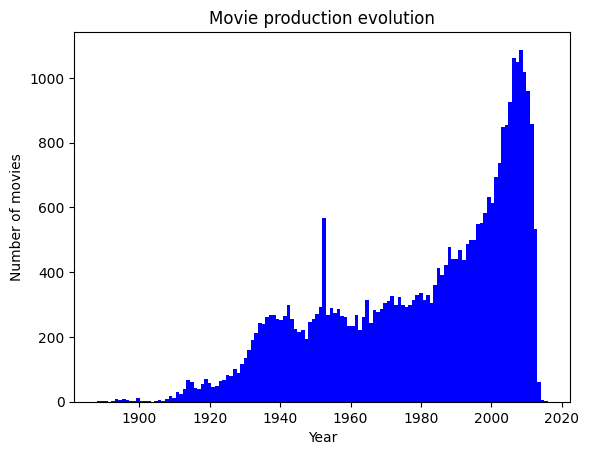

In [51]:
# 2.1 movie production evolution
# res
fig, ax = plt.subplots()
ax.hist(df["release_year"], bins=(2021-1895), color="blue")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.show()

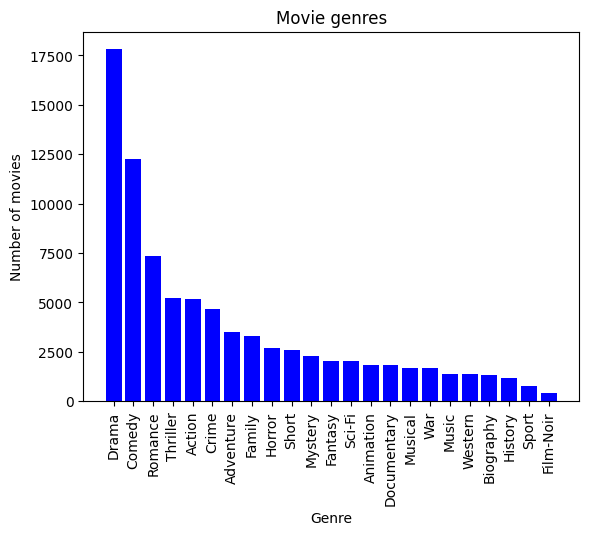

In [52]:

genres = df.genres.apply(lambda film: [genre for genre in literal_eval(film)]).explode().value_counts()
genres = genres[genres > 100]
fig, ax = plt.subplots()
ax.bar(genres.index, genres.values, color="blue")
ax.set_xlabel("Genre")
ax.set_ylabel("Number of movies")
ax.set_title("Movie genres")
plt.xticks(rotation=90)
plt.show()


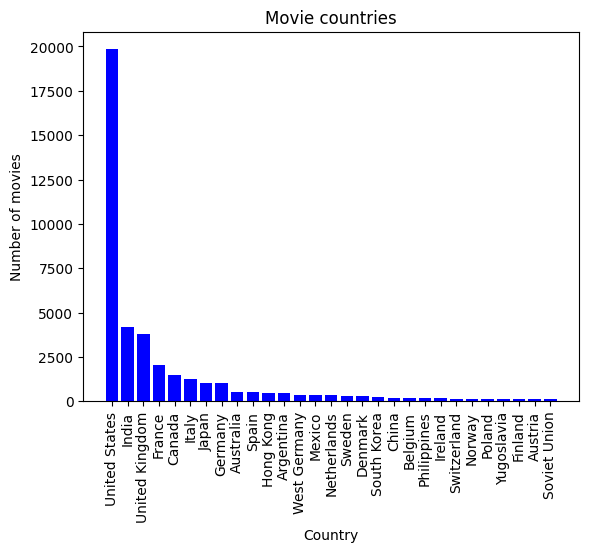

In [53]:
countries = df.countries.apply(lambda film: [country for country in literal_eval(film)]).explode().value_counts()
countries = countries[countries > 100]
fig, ax = plt.subplots()
ax.bar(countries.index, countries.values, color="blue")
ax.set_xlabel("Country")
ax.set_ylabel("Number of movies")
ax.set_title("Movie countries")
plt.xticks(rotation=90)
plt.show()

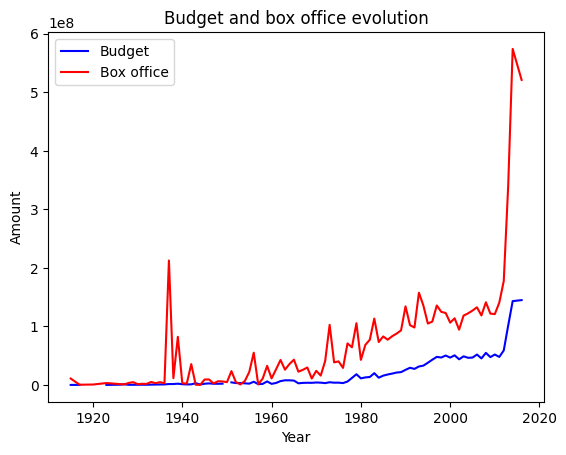

In [54]:
fig, ax = plt.subplots()
box_office_world = df[df["box_office_world"].notna()]
budget_by_year = box_office_world.groupby("release_year")["budget"].mean()
box_office_world_by_year = box_office_world.sort_values(["release_year"]).groupby("release_year")["box_office_world"].mean()
ax.plot(budget_by_year.index, budget_by_year.values, color="blue", label="Budget")
ax.plot(box_office_world_by_year.index, box_office_world_by_year.values, color="red", label="Box office")
ax.set_xlabel("Year")
ax.set_ylabel("Amount")
ax.set_title("Budget and box office evolution")
ax.legend()
plt.show()

#### Step 3: Box office feature analysis

#### Step 4: Finding correlation

#### Step 5: Predicting future production and box office

#### Step 6: Final visualisation of the datastory